In [10]:
import requests

def get_kanji(id):
    url = f"https://api.robanohashi.org/kanji/{id}"
    response = requests.get(url)
    return response.json()

In [11]:
get_kanji(500)['meanings']

[{'meaning': 'Inside', 'primary': True},
 {'meaning': 'Within', 'primary': False}]

In [12]:
from PIL import Image, ImageDraw, ImageFont

font = ImageFont.truetype("NotoSansJP-Regular.ttf", 200)
outpath = "kanji"

def kanji_to_image(kanji, output_file, padding=5, final_size=(100, 100)):
    size = font.getsize(kanji)
    temp_image = Image.new('L', size, color=0)
    draw = ImageDraw.Draw(temp_image)
    draw.text((0, 0), kanji, font=font, fill=255)

    # Calculate the bounding box of the text
    bbox = temp_image.getbbox()

    # Add padding to the bounding box
    padded_bbox = (
        max(0, bbox[0] - padding),
        max(0, bbox[1] - padding),
        min(size[0], bbox[2] + padding),
        min(size[1], bbox[3] + padding)
    )

    # Crop the image to the padded bounding box
    cropped_image = temp_image.crop(padded_bbox)

    # Create a quadratic grayscale image with a white background
    size = max(cropped_image.size)
    quadratic_image = Image.new('L', (size, size), color=0)

    # Paste the cropped image onto the quadratic image
    paste_position = (
        (size - cropped_image.size[0] + 1) // 2,
        (size - cropped_image.size[1] + 1) // 2
    )
    quadratic_image.paste(cropped_image, paste_position)

    # Resize the quadratic image to the final size
    final_image = quadratic_image.resize(final_size, Image.ANTIALIAS)

    final_image.save(output_file)


In [13]:
import os

if not os.path.exists(outpath):
    os.mkdir(outpath)

In [89]:
from tqdm import tqdm
metadata = []

for i in tqdm(range(440, 2467)):
    kanji = get_kanji(i)
    kanji_to_image(kanji['characters'], f"{outpath}/{kanji['characters']}.png")
    radicals = []
    for radical in kanji['component_subjects']:
        radicals.append({
            'characters': radical['characters'],
            'slug': radical['slug'],
            'id': radical['id']
        })
    meta = {
        'id': kanji['id'],
        'characters': kanji['characters'],
        'meanings': ','.join([m['meaning'] for m in kanji['meanings']]),
        'radicals': radicals,
    }

    metadata.append(meta)

100%|██████████| 2027/2027 [16:33<00:00,  2.04it/s]


In [109]:
# compress tar images
import tarfile
with tarfile.open('kanji.tar.gz', 'w:gz') as tar:
    tar.add(outpath, arcname=os.path.basename(outpath))

In [91]:
from datasets import Dataset
import pandas as pd

df = pd.DataFrame(metadata)
meta_ds = Dataset.from_pandas(df)
meta_ds.to_json('kanji_metadata.jsonl', orient='records', lines=True)


Creating json from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

367801

In [114]:
from datasets import load_dataset

ds = load_dataset('martingrzzler/kanjis2radicals')

Generating train split: 0 examples [00:00, ? examples/s]

Dataset kanjis2radicals downloaded and prepared to /root/.cache/huggingface/datasets/martingrzzler___kanjis2radicals/default/0.0.0/1f37c689ea24a3e304a3fcc2b5b4c52645add8e13b4eacb8cb26e4978da491a6. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
import requests

def get_radical(id):
    url = f"https://api.robanohashi.org/radical/{id}"
    response = requests.get(url)
    return response.json()

In [32]:
radical = get_radical(200)

In [33]:
radical['characters']

'乃'

In [267]:
!ls

MPLUS1-Regular.ttf	radicals     ZenKakuGothicNew-Regular.ttf
nohup.out		sample_data
NotoSansJP-Regular.ttf	test.png


In [273]:
import random
import os
from PIL import Image, ImageDraw, ImageFont

font = ImageFont.truetype("MPLUS1-Regular.ttf", 200)
outpath = "radicals"

In [277]:
!rm -rf radicals

In [278]:
if not os.path.exists(outpath):
    os.mkdir(outpath)

In [276]:
final_size = 100
def radical_to_image(radical, output_file, padding=5):
    size = font.getsize(radical)
    temp_image = Image.new('L', size, color=0)
    draw = ImageDraw.Draw(temp_image)
    draw.text((0, 0), radical, font=font, fill=255)

    # Calculate the bounding box of the text
    bbox = temp_image.getbbox()

    padded_bbox = (
        max(0, bbox[0] - padding),
        max(0, bbox[1] - padding),
        min(size[0], bbox[2] + padding),
        min(size[1], bbox[3] + padding)
    )

    # Crop the image to the padded bounding box
    cropped_image = temp_image.crop(padded_bbox)


    randomSize = random.randint(30,final_size-30)
    cropped_image = cropped_image.resize((randomSize, randomSize), Image.ANTIALIAS)

    quadratic_image = Image.new('L', (final_size, final_size), color=0)

    paste_position = (
        random.randint(0, final_size - randomSize),
        random.randint(0, final_size - randomSize)
    )

    quadratic_image.paste(cropped_image, paste_position)
    quadratic_image.save(output_file)

In [279]:
from tqdm import tqdm

meta_data = []

for i in tqdm(range(1, 440)):
    radical = get_radical(i)
    meta = {
        'id': radical['id'],
        'characters': radical['characters'],
        'slug': radical['slug']
    }

    for i in range(40):
        radical_to_image(radical['characters'], f"{outpath}/{radical['characters']}_{i + 1}.png")
        meta_data.append(meta)

100%|██████████| 439/439 [06:51<00:00,  1.07it/s]


In [280]:
# compress tar images
import tarfile
with tarfile.open('radicals.tar.gz', 'w:gz') as tar:
    tar.add(outpath, arcname=os.path.basename(outpath))

In [283]:
from datasets import Dataset
import pandas as pd

df = pd.DataFrame(meta_data)
meta_ds = Dataset.from_pandas(df)
meta_ds.to_json('radicals_metadata.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/18 [00:00<?, ?ba/s]

852680

In [286]:
from datasets import load_dataset

ds = load_dataset('martingrzzler/radicals')

Generating train split: 0 examples [00:00, ? examples/s]

Dataset radicals downloaded and prepared to /root/.cache/huggingface/datasets/martingrzzler___radicals/default/0.0.0/a789cd83e703618e8d8c908cf014dc4277ea3063f3e09bf1fd46e6f6e53a5b8b. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

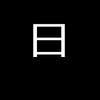

In [301]:
ds['train'][10001]['radical_image']